# Dimensionality Reduction

In [1]:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

Using NumPy's svd() function to obtain all the principal components of the training set:

In [2]:
X_centered = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:,0]
c2 = V.T[:,1]
c1, c2

(array([ 0.93636116,  0.29854881,  0.18465208]),
 array([-0.34027485,  0.90119108,  0.2684542 ]))

The following code projects the training set onto the plane definedd by the first 2 principal components

In [3]:
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)

Scikit's PCA class implements PCA using SVD decomposition just like we did before. The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note that it automatically takes care of centering the data).

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [5]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [6]:
pca.explained_variance_ratio_

array([ 0.84248607,  0.14631839])

The values above mean that 84.2% of the dataset's variance lies along the first axis, and 14.6% lies along the second axis. This leaves less than 1.2% for the third axis, so it is reasonable to assume that it probably carries little information. 

The following code computes PCA without reducing dimensionality, then computes the number of dimensions required to preserve 95% of the training set's variance:

In [7]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [8]:
d

2

Or you could do:

In [9]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X)

## MNIST Compression

In [10]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
mnist = fetch_mldata('MNIST original')

In [11]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [13]:
X_recovered = pca.inverse_transform(X_reduced)

In [14]:
def plot_digits(instances, images_per_row = 5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances)-1)//images_per_row+1
    row_images=[]
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row*images_per_row : (row+1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=plt.cm.binary, **options)
    plt.axis("off")

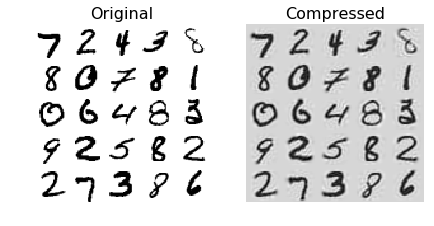

In [15]:
%matplotlib inline
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

## Incremental PCA

The following code splits the MNIST dataset into 100 mini-batches and feeds them to Scikit's IncrementalPCA class to reduce the dimensionality of the MNIST dataset down to 154 dimensions. Note that you must call the partial_fit() method with each mini-batch rather than the fit() method with the whole training set. 

In [17]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_mnist_reduced = inc_pca.transform(X_train)

Alternatively, you can use NumPy's memmap class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. 

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [24]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m,n))

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [25]:
del X_mm

Next, another program would load the data and use it for training:

In [26]:
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m,n))

batch_size = m//n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\decomposition\incremental_pca.py:249: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)


IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

## Stochastic PCA

In [27]:
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Kernel PCA

In [30]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components = 2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

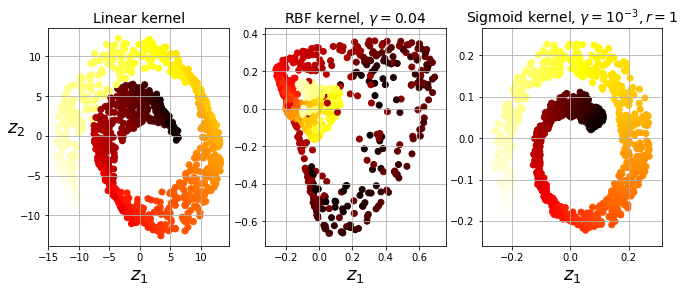

In [31]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

## Selecting Kernels and Tuning Parameters

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([('kpca', KernelPCA(n_components=2)), ('log_reg', LogisticRegression())])

param_grid = [{'kpca__gamma':np.linspace(0.03, .05, 10), 'kpca__kernel':['rbf','sigmoid']}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([ 0.03   ,  0.03222,  0.03444,  0.03667,  0.03889,  0.04111,
        0.04333,  0.04556,  0.04778,  0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The best kernel and parameters are then available using the following code:

In [37]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [38]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

Now we can compute the reconstruction pre-image error:

In [39]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766111

Now you can use grid search with cross-validation to find the kernel and hyperparameters that minimize this pre-image reconstruction error. 